In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from chin_chime.face_landmark_extractor import(
    save_landmarks, get_landmarks, process_video
)
import os

I0000 00:00:1725321730.491472 1188617 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1725321730.666108 1188702 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 555.42.02), renderer: NVIDIA RTX A5000/PCIe/SSE2
W0000 00:00:1725321730.667541 1188617 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1725321730.679216 1188704 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725321730.703962 1188714 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [2]:
videos_path = "/media/cv/Extreme Pro1/MERR/mer2023train/train"
csv_path = "/media/cv/Extreme Pro1/MERR/mer2023train/train-label.csv"


assert os.path.exists(csv_path)

In [3]:
def make_vid_path(filename, base_path):
    return os.path.join(base_path, filename + '.avi')

def load_csv(path, base_path):
    df = pd.read_csv(path)
    df['path'] = df['name'].apply(lambda x: make_vid_path(x, base_path))
    return df

df = load_csv(csv_path, videos_path)
df.head()

,name,discrete,valence,path
0,sample_00002721,neutral,-0.25,/media/cv/Extreme Pro1/MERR/mer2023train/train...
1,sample_00005854,angry,-2.50,/media/cv/Extreme Pro1/MERR/mer2023train/train...
2,sample_00003358,sad,-2.50,/media/cv/Extreme Pro1/MERR/mer2023train/train...
3,sample_00005933,happy,2.00,/media/cv/Extreme Pro1/MERR/mer2023train/train...
4,sample_00000613,angry,-1.75,/media/cv/Extreme Pro1/MERR/mer2023train/train...


In [4]:
saved_dataset_path = './dataset'

for emotion in df['discrete'].unique().tolist():
    os.makedirs(os.path.join(saved_dataset_path, emotion), exist_ok=True)
    emotion_path = os.path.join(saved_dataset_path, emotion)
    os.makedirs(os.path.join(emotion_path, 'images'), exist_ok=True)
    os.makedirs(os.path.join(emotion_path, 'landmarks'), exist_ok=True)
    
    

In [6]:
from tqdm import tqdm
save_folder = './dataset/'

failed_count = 0

for i, row in df.iterrows():
    path = row['path']
    emotion = row['discrete']
    filename = row['name']
    # try:
    #     process_video(path, emotion, save_folder)
    # except:
    #     failed_count += 1
    #     print(filename, failed_count)
        
    if i %500 == 0:
        print("Completed: ", i*100/df.shape[0], "%")

Completed:  0.0 %
Completed:  14.823599169878447 %
Completed:  29.647198339756894 %
Completed:  44.47079750963534 %
Completed:  59.29439667951379 %
Completed:  74.11799584939223 %
Completed:  88.94159501927068 %


In [32]:
import torch
import random
from torch.utils.data import Dataset, DataLoader, random_split


random.seed(42)


class LandMarks(Dataset):
    def __init__(self, dataset_path: str, mode: str, split: float=0.75):
        self.paths = self._load_paths(dataset_path, 'landmarks', mode, split)
        # if mode  == train: use first 75% of samples
        random.shuffle(self.paths)
        self.label2id = {'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4, 'worried': 5}
        self.id2label = {v:k for k, v in self.label2id.items()}
                
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        path = self.paths[index]
        item = torch.tensor(np.load(path), dtype=torch.float32)
        label = torch.tensor(self.label2id[path.split('/')[-3]])
        return (item, label)        
        
    def _load_paths(self, base_folder: str, type: str, mode: str, split: float) -> list:
        
        emotions = [os.path.join(base_folder, emo, type) for emo in os.listdir(base_folder)]
        paths = []
        for emo in emotions:
            files = os.listdir(emo)
            if mode == 'train':
                start = 0
                end = int(len(files) * split)
            elif mode == 'test':
                start = int(len(files) * split)
                end = len(files)
            else:
                raise ValueError("Sanity Check: No mode other than train and test is defined")
            files = files[start: end]
            for file in files:
                paths.append(os.path.join(emo, file))
        # paths = [os.path.join(emo, file) for emo in emotions for file in os.listdir(emo)]
        return paths


def split_dataset(dataset: Dataset, split: float, random_seed=42):
    g = torch.Generator().manual_seed(random_seed)
    if split > 0.99 or split < 0.1:
        raise ValueError("Split should be between 0.1 and 0.99")
    n1 = int(split * len(dataset))
    n2 = len(dataset) - n1
    train, test = random_split(dataset, [n1, n2], generator=g)
    
    return (train, test)

BATCH_SIZE = 32
# dataset = LandMarks(save_folder)
# train, test = split_dataset(dataset, 0.75, random_seed=42)
train_data = LandMarks('dataset_augmented/', 'train', 0.75)
test_data = LandMarks('dataset/', mode='test', split=0.75)

trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [33]:
len(train_data), len(test_data)

(38516, 6422)

In [34]:
import torch.nn as nn

class MLPLandmark(nn.Module):
    def __init__(self, inp_landmarks: int, out_dim: int, layers: list, dim_per_landmark: int=3):
        super().__init__()
        
        self.inp_dim = inp_landmarks * dim_per_landmark
        
        self.mlp = nn.ModuleList()
        
        self.mlp.append(nn.Linear(self.inp_dim, layers[0]))
        
        for i in range(1, len(layers)):
            self.mlp.append(
                nn.Sequential(
                    nn.Linear(layers[i-1], layers[i]),
                    nn.ReLU(),
                    nn.LayerNorm(layers[i])
                )
            )
        
        self.mlp.append(nn.Linear(layers[-1], out_dim))
        
    def forward(self, x: torch.Tensor):
        x = x.view(x.shape[0], self.inp_dim)
        
        for layer in self.mlp:
            x = layer(x)
        
        return x


device='cuda'
epochs = 200
lr = 1e-3


model = MLPLandmark(inp_landmarks=478, out_dim=6, layers=[100, 200, 500], dim_per_landmark=3).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [35]:
i, temp = next(enumerate(trainloader))

landmarks, labels = temp
logits = model(landmarks.to(device))
criterion(logits, labels.to(device))

tensor(1.9344, device='cuda:0', grad_fn=<NllLossBackward0>)

In [36]:
from sklearn.metrics import accuracy_score

test_acc = []
test_loss = [0]
train_loss = [0]
train_step = [0]


def train(weights_save_path):
    
    '''
    Updates the global variables need to check that
    '''
    model.train()
    
    eval_loss = 0.0
    eval_acc = 0.0
    max_eval_acc = -1
    
    for epoch in range(epochs):
        
        for i, batch in enumerate(trainloader):
            # zero gradients
            optimizer.zero_grad()
            
            landmarks, labels = batch
            landmarks: torch.Tensor =landmarks.to(device)
            labels: torch.Tensor = labels.to(device)
            
            logits = model(landmarks)
            loss: torch.Tensor = criterion(logits, labels)
            
            
            #back_prop
            loss.backward()
            optimizer.step()
            
            if i % 250 == 0:
                print(f"Epoch: {epoch} | Loss: {loss.item():.4f} | Last Eval Loss: {eval_loss:.4f}| Last Eval Accuracy: {eval_acc:.4f}")
            
            # track stats
            train_loss.append(loss.item())
            train_step.append(train_step[-1] + 1)
        
        # evaluate the model
        eval_loss, eval_acc = test()
        
        # track evaluation dataset stats
        test_acc.append(eval_acc)
        test_loss.append(eval_loss)
        
        # save the best model
        if eval_acc > max_eval_acc:
            torch.save(model.state_dict(), weights_save_path)
            max_eval_acc = eval_acc
        
    print("Evaluation Loss: ",  eval_loss, eval_acc)
    
    
@torch.no_grad()         
def test():
    preds_ = []
    labels_ = []
    eval_loss = []
    model.eval()
    for i, batch in enumerate(testloader):
        
        landmarks, labels = batch
        landmarks = landmarks.to(device)
        labels = labels.to(device)
        
        logits = model(landmarks)
        
        preds = torch.argmax(logits, dim=1)
        preds_.extend((preds.cpu().tolist()))
        labels_.extend(labels.cpu().tolist())
        
        loss = criterion(logits, labels)
        
        eval_loss.append(loss.item())
    
    return (sum(eval_loss)/len(eval_loss), accuracy_score(preds_, labels_))


In [ ]:
test_acc = []
test_loss = [0]
train_loss = [0]
train_step = [0]

train('./model_weights/landmark_emotion.pt')

Text(0, 0.5, 'Loss')

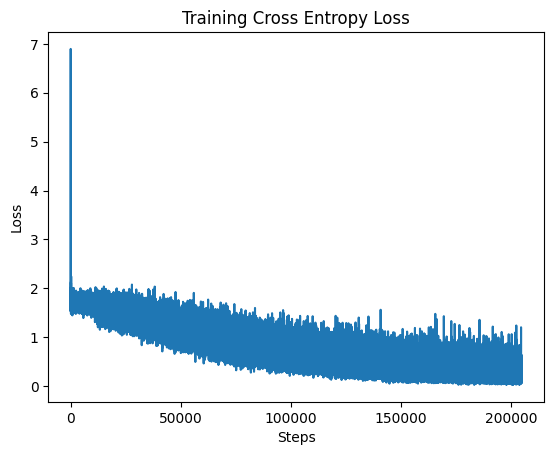

In [38]:
import matplotlib.pyplot as plt

plt.plot(train_step[1:], train_loss[1:])
plt.title("Training Cross Entropy Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy Score %')

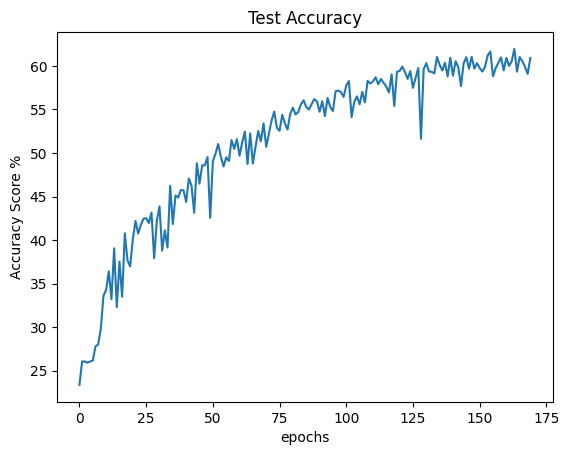

In [39]:
plt.plot(np.array(test_acc) * 100)
plt.title("Test Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy Score %")

In [43]:
class LandMarksLower(Dataset):
    def __init__(self, dataset_path: str, mode: str, split: float=0.75):
        self.paths = self._load_paths(dataset_path, 'landmarks', mode, split)
        random.shuffle(self.paths)
        self.label2id = {'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4, 'worried': 5}
        self.id2label = {v:k for k, v in self.label2id.items()}
        self.lower_landmark_ids = self._get_lower_face_landmark_ids()
        
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        path = self.paths[index]
        item = torch.tensor(np.load(path), dtype=torch.float32)
        item = item[self.lower_landmark_ids]
        label = torch.tensor(self.label2id[path.split('/')[-3]])
        return (item, label)        
        
    def _load_paths(self, base_folder: str, type: str, mode: str, split: float) -> list:
        
        emotions = [os.path.join(base_folder, emo, type) for emo in os.listdir(base_folder)]
        paths = []
        for emo in emotions:
            files = os.listdir(emo)
            if mode == 'train':
                start = 0
                end = int(len(files) * split)
            elif mode == 'test':
                start = int(len(files) * split)
                end = len(files)
            else:
                raise ValueError("Sanity Check: No mode other than train and test is defined")
            files = files[start: end]
            for file in files:
                paths.append(os.path.join(emo, file))
        # paths = [os.path.join(emo, file) for emo in emotions for file in os.listdir(emo)]
        return paths
    
    def _get_lower_face_landmark_ids(self):
        # Dictionary of lower face landmarks
        lower_face_landmarks = {
            "jawline": list(range(0, 17)),  # Landmarks 0 to 16
            "chin": [152],  # Landmark 152

            "outer_lip_contour": list(range(61, 69)) + list(range(75, 79)) + list(range(191, 196)) + [61, 291],
            # Landmarks 61-68, 75-78, 191-195, 61 (left corner), 291 (right corner)
            
            "inner_lip_contour": list(range(78, 83)) + list(range(87, 92)) + [88, 324],
            # Landmarks 78-82, 87-91, 88 (left corner), 324 (right corner)

            "lower_cheek_contours": list(range(127, 133)) + list(range(134, 137)) + [147, 148],
            # Landmarks 127-132, 134-136, 147-148

            "chin_to_lip_connection": list(range(17, 21)) + [317, 318]
            # Landmarks 17-20, 317-318
        }

        # Convert all landmark indices to a single list
        all_landmarks = []

        # Iterate over the dictionary and extend the list with each set of landmarks
        for key, indices in lower_face_landmarks.items():
            all_landmarks.extend(indices)

        # Remove duplicates by converting to a set and then back to a sorted list
        unique_landmarks = sorted(set(all_landmarks))

        # Print the resulting list of unique landmarks
        return unique_landmarks


BATCH_SIZE = 64
# dataset = LandMarksLower(save_folder)
# train, test = split_dataset(dataset, 0.75, random_seed=42)

train_data = LandMarksLower('dataset_augmented/', mode='train', split=0.75)
test_data = LandMarksLower('dataset/', mode='test', split=0.75)
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [44]:
model = MLPLandmark(inp_landmarks=63, out_dim=6, layers=[100, 200, 500], dim_per_landmark=3).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
test_acc = []
test_loss = [0]
train_loss = [0]
train_step = [0]

epochs = 200

train('./model_weights/landmark_lower_emotion.pt')

Text(0, 0.5, 'Loss')

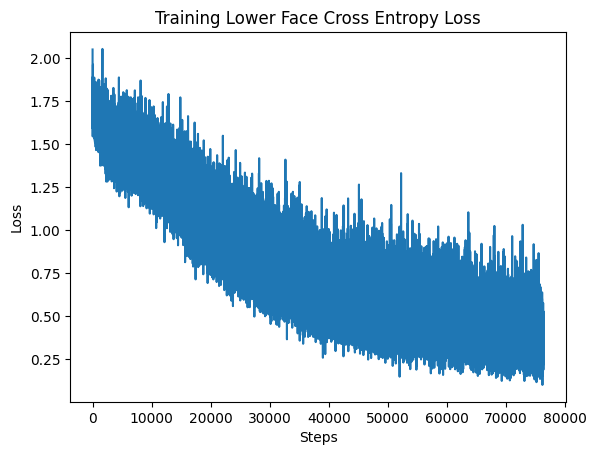

In [46]:
import matplotlib.pyplot as plt

plt.plot(train_step[1:], train_loss[1:])
plt.title("Training Lower Face Cross Entropy Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")

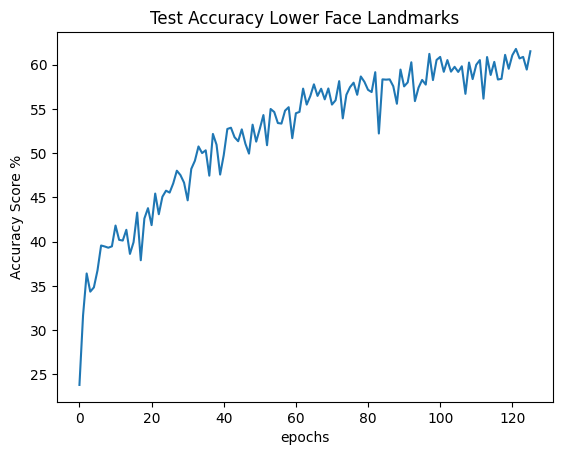

In [47]:
plt.plot(np.array(test_acc) * 100)
plt.title("Test Accuracy Lower Face Landmarks")
plt.xlabel("epochs")
plt.ylabel("Accuracy Score %")
plt.show()

In [86]:
class LandMarksLowerTemporal(Dataset):
    def __init__(self, dataset_path: str, mode: str, split: float=0.75):
        self._paths = self._load_paths(dataset_path, 'landmarks_temporal', mode, split)
        
        self.paths = []
        for path in tqdm(self._paths):
            item = np.load(path)
            if item.shape[0] != 0:
                self.paths.append(path)
            else:
                print("nothing saved")
        random.shuffle(self.paths)
        
          
        self.label2id = {'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4, 'worried': 5}
        self.id2label = {v:k for k, v in self.label2id.items()}
        self.lower_landmark_ids = self._get_lower_face_landmark_ids()
           
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        path = self.paths[index]
        item = torch.tensor(np.load(path), dtype=torch.float32)
        item = item[:, self.lower_landmark_ids]
        label = torch.tensor(self.label2id[path.split('/')[-3]])
        return (item, label)        
        
    def _load_paths(self, base_folder: str, type: str, mode: str, split: float) -> list:
        
        emotions = [os.path.join(base_folder, emo, type) for emo in os.listdir(base_folder)]
        paths = []
        for emo in emotions:
            files = os.listdir(emo)
            if mode == 'train':
                start = 0
                end = int(len(files) * split)
            elif mode == 'test':
                start = int(len(files) * split)
                end = len(files)
            else:
                raise ValueError("Sanity Check: No mode other than train and test is defined")
            files = files[start: end]
            for file in files:
                paths.append(os.path.join(emo, file))
        # paths = [os.path.join(emo, file) for emo in emotions for file in os.listdir(emo)]
        return paths
    
    def _get_lower_face_landmark_ids(self):
        # Dictionary of lower face landmarks
        lower_face_landmarks = {
            "jawline": list(range(0, 17)),  # Landmarks 0 to 16
            "chin": [152],  # Landmark 152

            "outer_lip_contour": list(range(61, 69)) + list(range(75, 79)) + list(range(191, 196)) + [61, 291],
            # Landmarks 61-68, 75-78, 191-195, 61 (left corner), 291 (right corner)
            
            "inner_lip_contour": list(range(78, 83)) + list(range(87, 92)) + [88, 324],
            # Landmarks 78-82, 87-91, 88 (left corner), 324 (right corner)

            "lower_cheek_contours": list(range(127, 133)) + list(range(134, 137)) + [147, 148],
            # Landmarks 127-132, 134-136, 147-148

            "chin_to_lip_connection": list(range(17, 21)) + [317, 318]
            # Landmarks 17-20, 317-318
        }

        # Convert all landmark indices to a single list
        all_landmarks = []

        # Iterate over the dictionary and extend the list with each set of landmarks
        for key, indices in lower_face_landmarks.items():
            all_landmarks.extend(indices)

        # Remove duplicates by converting to a set and then back to a sorted list
        unique_landmarks = sorted(set(all_landmarks))

        # Print the resulting list of unique landmarks
        return unique_landmarks
    

class LSTMLandmark(nn.Module):
    def __init__(self, lstm_hidden_size: int, inp_landmarks: int, out_dim: int, layers: list, dim_per_landmark: int=3):
        super(LSTMLandmark, self).__init__()
        self.inp_dim = inp_landmarks * dim_per_landmark
        self.lstm = nn.LSTM(input_size=self.inp_dim, hidden_size=lstm_hidden_size, batch_first=True)
        
        # MLP layers
        self.mlp = nn.ModuleList()
        self.mlp.append(nn.Linear(lstm_hidden_size, layers[0]))
        for i in range(1, len(layers)):
            self.mlp.append(
                nn.Sequential(
                    nn.Linear(layers[i-1], layers[i]),
                    nn.ReLU(),
                    nn.LayerNorm(layers[i])
                    )
                )
            
        self.mlp.append( nn.Linear(layers[-1], out_dim))
        
    def forward(self, x):
        # Reshape input: (batch_size, 10, 63, 3) -> (batch_size, 10, 63*3)
        x = x.view(x.size(0), x.size(1), self.inp_dim)
        # LSTM forward pass: output shape (batch_size, 10, lstm_hidden_size)
        lstm_out, (hn, cn) = self.lstm(x)
        
        # Use the last hidden state: shape (batch_size, lstm_hidden_size)
        x = hn[-1]
        
        # MLP forward pass
        for layer in self.mlp:
            x = layer(x)    
        
        return x



In [87]:
batch_size = 32
lstm_hidden_size = 128
mlp_hidden_size = 64
num_classes = 7

model = LSTMLandmark(
    lstm_hidden_size=lstm_hidden_size, 
    inp_landmarks=63,
    out_dim=6,
    layers=[100,200,500],
    dim_per_landmark=3).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [88]:
BATCH_SIZE = 64
# dataset = LandMarksLower(save_folder)
# train, test = split_dataset(dataset, 0.75, random_seed=42)

train_data = LandMarksLowerTemporal('dataset_augmented/', mode='train', split=0.75)
test_data = LandMarksLowerTemporal('dataset_augmented/', mode='test', split=0.75)
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE)
len(train_data), len(test_data)

  0%|          | 0/2275 [00:00<?, ?it/s]

100%|██████████| 762/762 [00:00<00:00, 3186.09it/s]

nothing saved


(2275, 761)

In [89]:
test_acc = []
test_loss = [0]
train_loss = [0]
train_step = [0]

epochs = 200

train('./model_weights/landmark_lower_temporal_emotion.pt')

Epoch: 0 | Loss: 1.9230 | Last Eval Loss: 0.0000| Last Eval Accuracy: 0.0000


RuntimeError: cudnn RNN backward can only be called in training mode